#### Problem Statement
1. As an attacker, I **put devices** in a pre-defined area.
   - How I put the devices will be shown later.
   - I only care about users in this area.
   - I use these devices to collection **TraceTogether data**, i.e. (device_id, walker_id, time, distance)
1. From all these (device_id, walker_id, time, distance) pairs, I know some different walker_ids are in fact from the SAME walker passed by.
1. I want to connect the path generated by each walker together, i.e. **group walker_ids** into groups of real_ids

In [1]:
%load_ext autoreload
%autoreload 2
import sqlite3
import operator
import pandas as pd
import collections
import networkx as nx
utils = __import__('04.utils', fromlist=['object'])

### Analytical

1. I cannot know the velocity at each point which is the key point for determining the velocity at next time interval.
1. Necessary information is lost for analytical

### Statistical
1. Since I only know the distance between device and walkers, I **cannot know the precise location** of each walker, and thus I **cannot know the precise velocity**.
1. I use the location of the devices to **estimate the actual location** of walker.
    - If a person is tracked by a device, I assume the person is at the position of the device.
    - If a person is tracked by multiple devices, I assume the person is at the position of the **closest** device.
1. I only care about walks within the area under my surveillance, thus **only walks that passed by that area** will be generated and collected.
    - This will make the data denser.
1. Generate a training dataset: where I know real_id and thus the whole path for a person.
    For each walker with **real_id**:
        Each time he moves from device x to device y
        x->y: +1
        This means the probability of a person moving from x to y is updated
1. For testing data:
    For each walker with **walker_id**:
        I know its time t and device position x
        Get all walkers position y at time t+1
        Find the maximum x->y, y is predicated to be the next position of x
        
#### Accuracy Measurement
All ids mentioned below can duplicate because I bound them with time t (Because I'm dealing with each point instead of each id).  
However, when it is updated, all duplicated ids will be update/group **together** (Because it will be grouped together and update to a single new id). So it will not affect the result.  
1. Count the number of correctly grouped ids. -> correct
1. Count the number of grouped ids. -> tried
1. The number of walker ids.
1. correctness=correct/tried, accuracy=correct/total, baseline=(number of same walker id in one time interval)/total

In [2]:
%load_ext autoreload
%autoreload 2
import json
import sqlite3
import pandas as pd
import collections
import networkx as nx
import math
import statistics
utils = __import__('04.utils', fromlist=['object'])

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Training

In [3]:
cnx = sqlite3.connect('../corona-sniffer/backend/data/database_3000.db')

df_walks = pd.read_sql_query("SELECT * FROM walks JOIN walkers ON walkers.id = walks.walker_id", cnx)
df_walkers = pd.read_sql_query("SELECT * FROM walkers", cnx)
df_contacts = pd.read_sql_query("SELECT * FROM contacts", cnx)
df_agents = pd.read_sql_query("SELECT * FROM agents", cnx)

In [4]:
id_to_pos, pos_to_id = utils.get_position(df_agents)

In [5]:
prob_agent_id_tmp, prob_dir = utils.get_agent_next_prob(df_walkers, df_contacts)

In [6]:
prob_pos = utils.map_prob_to_pos(prob_agent_id_tmp, id_to_pos)

## Predicting

In [7]:
cnx = sqlite3.connect('../corona-sniffer/backend/data/database_3000_test.db')

df_walks = pd.read_sql_query("SELECT * FROM walks JOIN walkers ON walkers.id = walks.walker_id", cnx)
df_walkers = pd.read_sql_query("SELECT * FROM walkers", cnx)
df_contacts = pd.read_sql_query("SELECT * FROM contacts", cnx)
df_agents = pd.read_sql_query("SELECT * FROM agents", cnx)

In [8]:
"""
Get counter of agent_id Key -> agent_id Values
"""
id_to_pos, pos_to_id = utils.get_position(df_agents)
prob_agent_id = utils.map_prob_to_agent_id(prob_pos, pos_to_id)

In [9]:
"""
# agent_id -> next_agent_id
sparse data
"""
print(collections.Counter([i for dic in prob_agent_id.values() for _, i in dic.items()]))

Counter({1: 769, 2: 498, 3: 397, 4: 297, 5: 235, 6: 199, 7: 124, 8: 98, 9: 67, 10: 63, 11: 55, 14: 39, 12: 39, 13: 37, 16: 24, 15: 18, 20: 15, 18: 15, 22: 14, 19: 10, 17: 9, 23: 8, 21: 8, 25: 8, 24: 7, 27: 3, 38: 3, 26: 3, 32: 2, 37: 2, 42: 2, 29: 2, 28: 1, 34: 1, 33: 1, 52: 1, 47: 1})


In [10]:
INTERVAL = 60
TIME_PERIOD = 1
SCALE_METERS = 1500
scaleMeters = SCALE_METERS * 0.2
SIGMA_V = scaleMeters / 100

DEBUG = False
"""
Map agent id to its most possible next agent.
"""
link_list = {}
walker_ids = set(df_contacts['walker_id'].tolist())
for walker_id1 in walker_ids:
    time = sorted(set(df_contacts.loc[df_contacts['walker_id'] == walker_id1]['time'].tolist()))
    time1 = time[-1]
    
    # in case there're multiple agents tracking the walker
    last_rows = df_contacts.loc[(df_contacts['walker_id'] == walker_id1) & (df_contacts['time'] == time1)]
    pre_rows = df_contacts.loc[(df_contacts['walker_id'] == walker_id1) & (df_contacts['time'] == str(int(time1) - 60))]
    if last_rows.shape[0] == 0 or pre_rows.shape[0] == 0:
        continue
        
    if DEBUG: print('walker_id1: {}, time: {}, # last_rows: {}, # pre_rows: {}'.format(walker_id1, time, last_rows.shape, pre_rows.shape))
        
    # among all the tracked records, consider mean velocity as real velocity
    vx, vy = utils.get_mean_v(last_rows, pre_rows)
    
    # get candidate points by time
    candidates = df_contacts.loc[df_contacts['time'] == str(int(time1) + 60)]
    if candidates.shape[0] == 0:
        continue
    
    candidate_agent_probs = {}
    for _, row1 in last_rows.iterrows():
        agent_id1, time1 = row1['agent_id'], row1['time']
        json1 = json.loads(row1['json'])['agentPos']
    
        for _, row2 in candidates.iterrows():
            res = ''
            
            agent_id2, walker_id2 = row2['agent_id'], row2['walker_id']
            json2 = json.loads(row2['json'])['agentPos']
            
            new_prob = 0
            
            # direct
            new_prob += utils.get_direct_prob(prob_agent_id, agent_id1, agent_id2)
            res += 'direct: ' + str(new_prob)

            # distance
            new_prob += utils.get_dis_prob(json1, json2, vx, vy)
            if new_prob == -float('inf'):
                continue
            res += ', distance: ' + str(new_prob)
            
            # direction
            new_prob += utils.get_direction_prob(json1, json2, prob_dir)
            res += ', directions: ' + str(new_prob)
                
            if DEBUG: print(res)
                
            # a walker's probability to be the next step is the average probability
            weight = json.loads(row2['json'])['distance']
            candidate_agent_probs[walker_id2] = utils.get_avg_prob(candidate_agent_probs, walker_id2, new_prob, weight)
            
    if DEBUG: print(candidate_agent_probs)
        
    link_list[walker_id1] = max(candidate_agent_probs.items(), key=operator.itemgetter(1))[0]

In [11]:
"""
Connect each linked path into a single path
"""
graph = nx.Graph([(i, j) for i, j in link_list.items() if i and j])
connected_components = sorted(nx.connected_components(graph), key=len, reverse=True)
print(len(connected_components))

df_walks_connected = pd.DataFrame(df_walks)
for i, component in enumerate(connected_components):
    new_id = i
    time_set = set()
    for c in component:
        rows = df_walks_connected.loc[df_walks_connected['walker_id'] == c]
        
        cyclic = False
        for time in rows['walk_time'].tolist():
            if time in time_set:
                cyclic = True
                break
            else:
                time_set.add(time)
        if cyclic:
            continue
        else:
            tmp = c
            df_walks_connected = df_walks_connected.replace({'walker_id': {c: str(new_id) + 'tmp'}})

10


In [12]:
walker_ids = set(df_walks_connected['walker_id'].tolist())
correct, total, tried = 0, 0, 0
for walker_id in walker_ids:
    id_list = df_walks_connected.loc[df_walks_connected['walker_id'] == walker_id].sort_values('walk_time')['real_id'].tolist()
    dic = collections.Counter(id_list)
    
    l = max(dic.values())
    key = [k for k,v in dic.items() if v == l]
    
    correct += l
    tried += sum([v if isinstance(k, int) or k[:-3].isdigit() else 0 for k, v in dic.items()])
    total += sum([v for v in dic.values()])

print(f'correct/tried: {correct}/{tried} {correct/tried*100}%') 
print(f'correct/total: {correct}/{total} {correct/total*100}%')

correct/tried: 1470/1500 98.0%
correct/total: 1470/1500 98.0%


In [13]:
real_ids = set(df_walks_connected['real_id'].tolist())
correct, total, tried = 0, 0, 0
for real_id in real_ids:
    id_list = df_walks_connected.loc[df_walks_connected['real_id'] == real_id].sort_values('walk_time')['walker_id'].tolist()
    dic = collections.Counter(id_list)
    
    l = max(dic.values())
    key = [k for k,v in dic.items() if v == l]
    
    correct += l
    tried += sum([v if isinstance(k, int) or k[:-3].isdigit() else 0 for k, v in dic.items()])
    total += sum([v for v in dic.values()])
    df_walks_connected = df_walks_connected.replace({'walker_id': {key[0]: int(real_id)}})
print(f'correct/tried: {correct}/{tried} {correct/tried*100}%') 
print(f'correct/total: {correct}/{total} {correct/total*100}%')

correct/tried: 1381/1411 97.87384833451452%
correct/total: 1381/1500 92.06666666666666%


In [14]:
cnx.execute('DROP TABLE IF EXISTS walks_attached')
df_walks_connected.to_sql('walks_attached', con=cnx)

In [15]:
df_walks_connected

,walker_id,walk_time,x,y,json,id,id_time,real_id,resolved
0,0,1610445512,259.317659236627,359.05660181631,"{""resolved"":false,""location"":{""latitude"":60.16...",b4ff558e32ebc36ee610,1610445235,0,0
1,0,1610445692,202.397212678868,261.363709478869,"{""resolved"":false,""location"":{""latitude"":60.16...",b4ff558e32ebc36ee610,1610445235,0,0
2,0,1610445572,240.480428727696,323.581543327113,"{""resolved"":false,""location"":{""latitude"":60.16...",b4ff558e32ebc36ee610,1610445235,0,0
3,0,1610445872,143.555421257707,173.335928671788,"{""resolved"":false,""location"":{""latitude"":60.16...",4f46d1573034952f4087,1610445835,0,0
4,0,1610445932,128.4005590435,143.023171622406,"{""resolved"":false,""location"":{""latitude"":60.16...",4f46d1573034952f4087,1610445835,0,0
...,...,...,...,...,...,...,...,...,...
1495,9,1610454332,369.497484101045,-582.12954450743,"{""resolved"":false,""location"":{""latitude"":60.15...",58d9ba57dbf71383d8ae,1610453836,9,0
1496,9,1610454452,406.480448994611,-597.809181607441,"{""resolved"":false,""location"":{""latitude"":60.15...",2ca1f723efab8760665c,1610454436,9,0
1497,40a22c4b8f22776f2c57,1610445692,177.942956306506,-254.775464507956,"{""resolved"":false,""location"":{""latitude"":60.16...",40a22c4b8f22776f2c57,1610445290,7,0
1498,9,1610445632,-296.186285440652,295.461672103098,"{""resolved"":false,""location"":{""latitude"":60.16...",6e5652810a1b2a24f2a4,1610445436,9,0


In [16]:
component

{'10b2e4d9f643f9f7d7e6',
 '1958938444904f00e069',
 '1aeca0e9ea5b51fd8deb',
 '34a0b6c0478cc09fbd46',
 '57bc66a19020f8ff4bda',
 '6acc6d732519fc45db7a',
 '7c68bf863c7e45ca0c63',
 'acdff6b4e822df3ccaf7',
 'bdaa9188f2c28df17fa8',
 'c57d3cfd8af9943d9c30',
 'f2d461c50cfc64b9be5b'}

Populating the interactive namespace from numpy and matplotlib


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['time']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


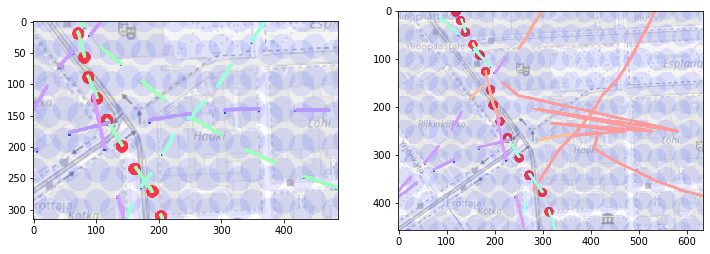

In [17]:
%pylab inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

f, axarr = plt.subplots(1, 2, figsize=(12, 12))
img1 = mpimg.imread('04/1.png')
img2 = mpimg.imread('04/2.png')
imgplot = axarr[0].imshow(img1)
imgplot = axarr[1].imshow(img2)
plt.show()

1. The points are all within one device's range. They are undistinguishable when being predicated.
    - They don't have to be very close, just tracked by the same device can cause this problem.
    - Getting the one closer to the current device may solve the problem.
        - Need devices range overlap each other for this information.

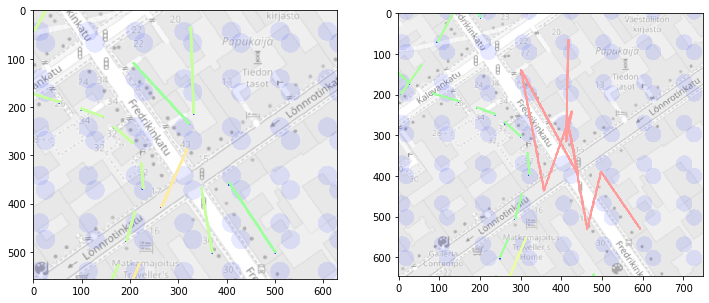

In [18]:
f, axarr = plt.subplots(1, 2, figsize=(12, 12))
img1 = mpimg.imread('04/3.png')
img2 = mpimg.imread('04/4.png')
imgplot = axarr[0].imshow(img1)
imgplot = axarr[1].imshow(img2)
plt.show()

Direction causing problem as well.